# Описательные статистики

Провести EDA (подсчет и визуализация описательных статистик, поиск и отсечение выбросов, решение проблемы с пропусками, взаимная корреляция) http://lib.stat.cmu.edu/DASL/Datafiles/Colleges.html (про задачу http://lib.stat.cmu.edu/DASL/Stories/ComparingColleges.html)

    * Подсчет и визуализация описательных статистик
    * Поиск и отсечение выбросов. Визуализация данных с выбросами и без.
    * Поиск и обработка пропущенных значений
    * Визуализация и объяснение взаимокорреляции

In [306]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Загрузим датасет, посмотрим, есть ли пропуски.

In [336]:
df = pd.read_csv('./colleges.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Amherst to U of Rochester
Data columns (total 7 columns):
School_Type    50 non-null object
SAT            50 non-null int64
Acceptance     50 non-null int64
$/Student      50 non-null int64
Top 10%        50 non-null int64
%PhD           50 non-null int64
Grad%          50 non-null int64
dtypes: int64(6), object(1)
memory usage: 3.1+ KB


Пропусков нет, замечательно, обрабатывать пропущенные значения не нужно...? Построим boxplots.

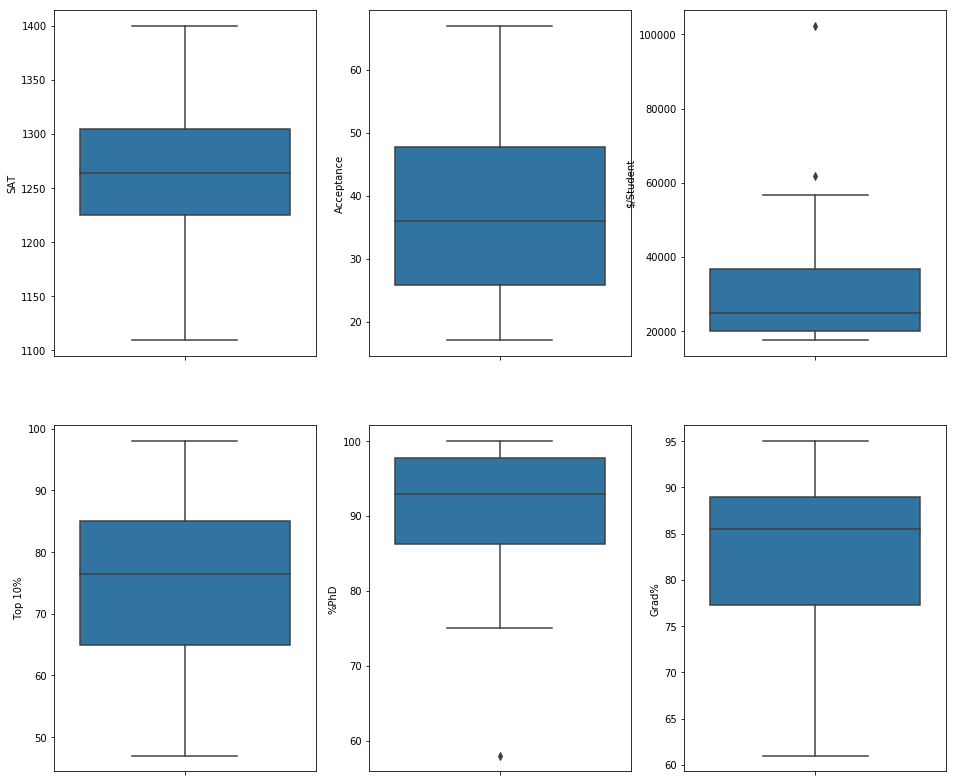

In [156]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 14))
for (index, col) in enumerate(['SAT', 'Acceptance', '$/Student', 'Top 10%', '%PhD', 'Grad%']):
    sns.boxplot(data=df, y=col, ax=axes[index//3][index%3])

* SAT. Хороший график, коробочка посередине, есть подозрение, что там что-то околонормальное. Проверим.
* Acceptace. Большой разброс, хотя чуть меньше, чем на других графиках.
* $/Student. Есть два особенных универа, выделяющих на студентов **существенно** больше денег, чем остальные. Явные выбросы.
* Top 10\%. Снова большой разброс, но ничего сверхъестественного нет. Здесь тоже стоит построить distplot.
* \%PhD. Не такой уж большой разброс, но есть один суперзаметный выброс. Наверное, преподают в этом универе вчерашние студенты.
* Grad\%. Разброс есть, но ничего необычного.

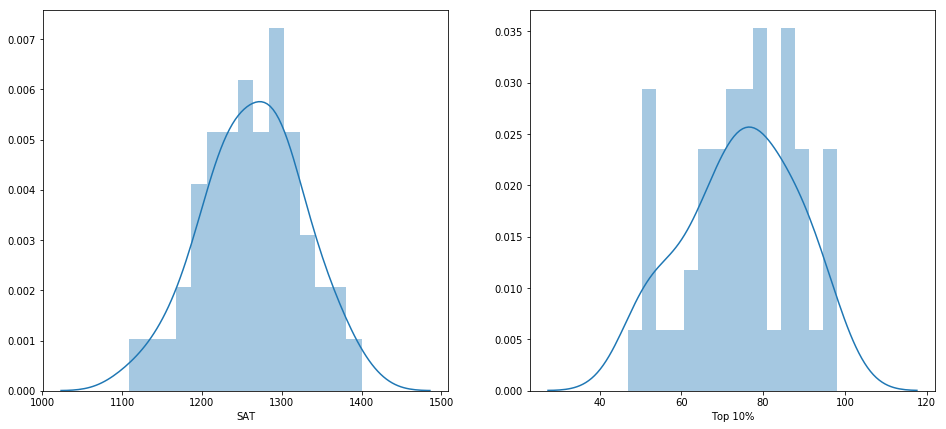

In [180]:
f, axes = plt.subplots(ncols=2, figsize=(16, 7))
sns.distplot(df['SAT'], bins=15, ax=axes[0])
sns.distplot(df['Top 10%'], ax=axes[1], bins=15)

Да, SAT действительно, похоже, нормально распределен. А вот с Top 10% явно промах. Построим pairplots.

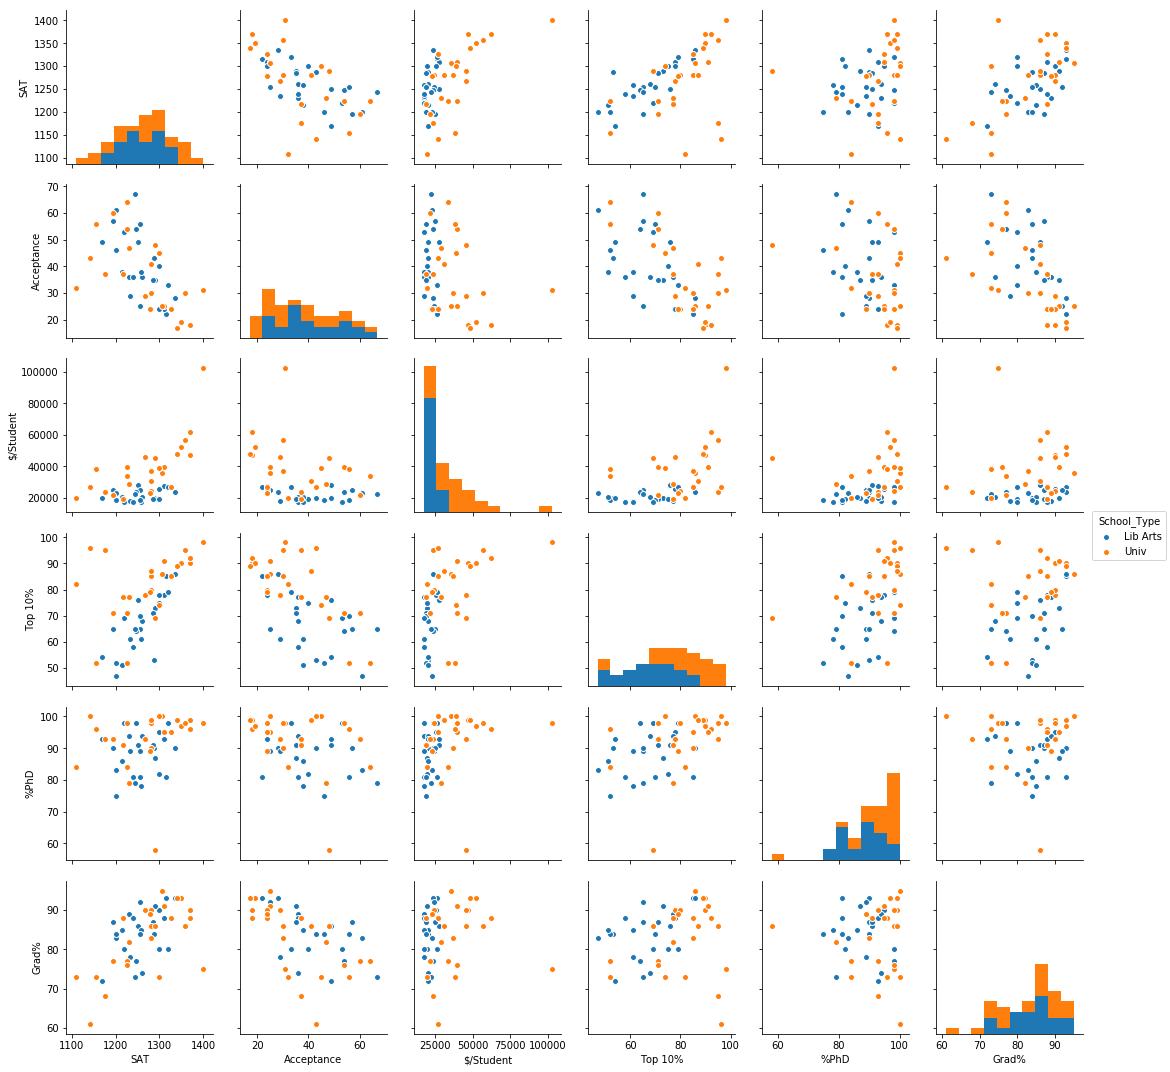

In [135]:
sns.pairplot(df, hue='School_Type')

Кажется, есть заметная корреляция между признаками Top 10% и SAT, Grad% и SAT. Проверим, построим heatmap корреяционной матрицы.

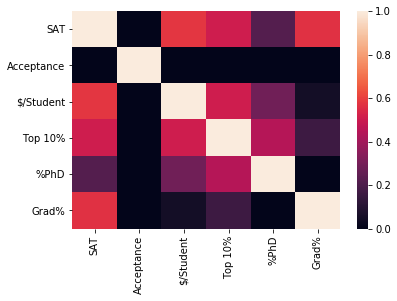

In [309]:
sns.heatmap(df.corr(), vmin=0, vmax=1)

Если честно, то очевидней не стало, посмотрим на циферки

In [310]:
df.corr()

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
SAT,1.000000,-0.606753,0.579423,0.509260,0.220944,0.569126
Acceptance,-0.606753,1.000000,-0.288819,-0.616328,-0.311665,-0.562211
$/Student,0.579423,-0.288819,1.000000,0.509948,0.286665,0.051055
Top 10%,0.509260,-0.616328,0.509948,1.000000,0.448616,0.161335
%PhD,0.220944,-0.311665,0.286665,0.448616,1.000000,-0.055403
Grad%,0.569126,-0.562211,0.051055,0.161335,-0.055403,1.000000


Да, действительно, между признаками Top 10% и SAT, Grad% и SAT есть неплохая корреляция, однако далеко не самая большая. Попробуем удалить те несколько выбросов (и еще несколько), которые были видны на boxplots и посмотреть, что изменится.

In [351]:
df = df.drop(df[df['%PhD'] < 70].index)
df = df.drop(df[df['$/Student'] > 60000].index)
df = df.drop(df[df['Grad%'] < 70].index)
df = df.drop(df[df['SAT'] < 1150].index)

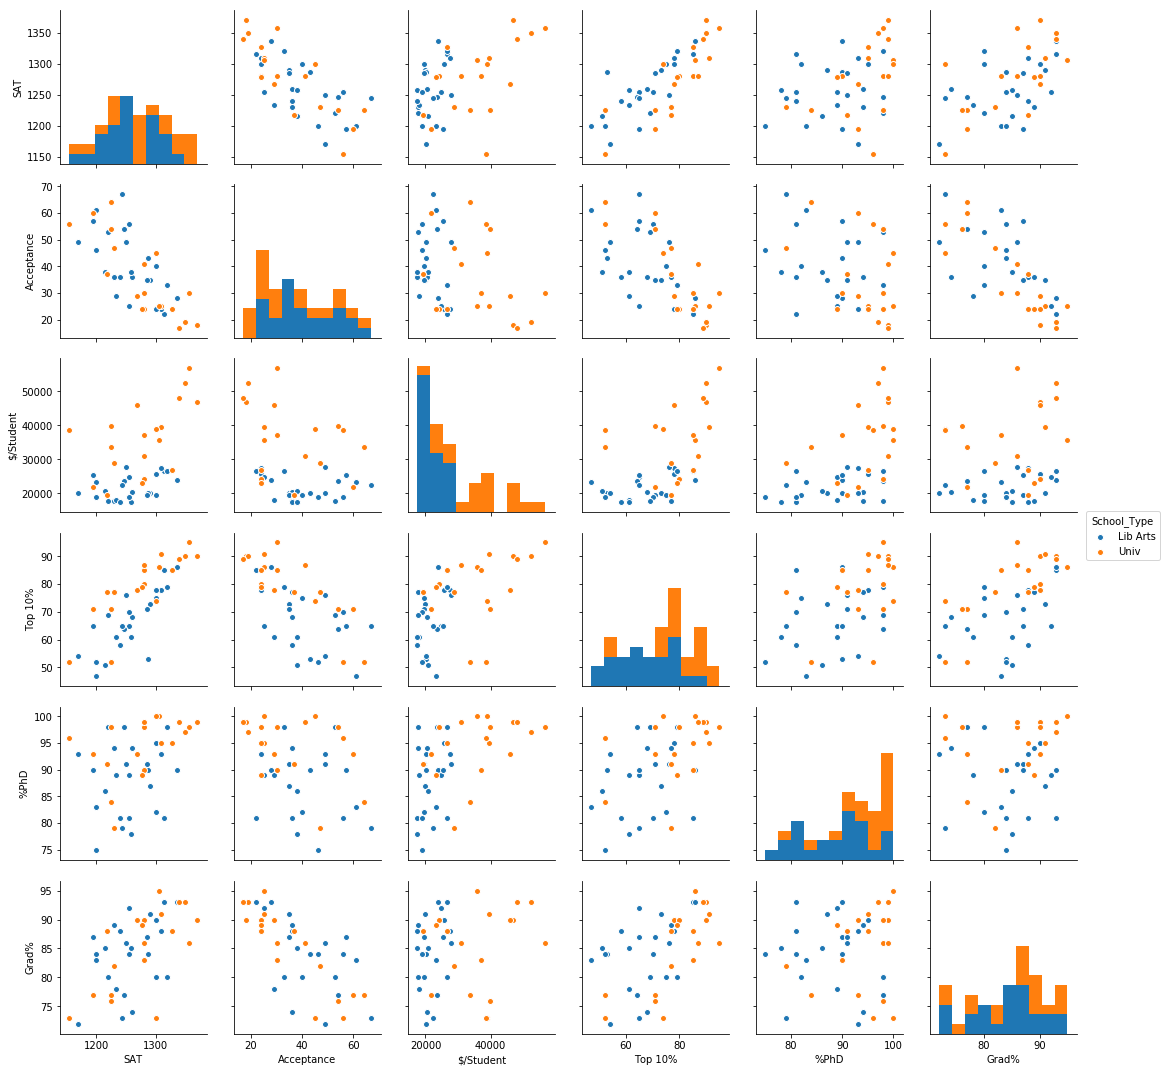

In [352]:
sns.pairplot(df, hue='School_Type')

In [353]:
df.corr()

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
SAT,1.000000,-0.737802,0.483846,0.781033,0.337845,0.556016
Acceptance,-0.737802,1.000000,-0.315032,-0.652275,-0.314690,-0.722072
$/Student,0.483846,-0.315032,1.000000,0.544598,0.509725,0.188205
Top 10%,0.781033,-0.652275,0.544598,1.000000,0.484270,0.544853
%PhD,0.337845,-0.314690,0.509725,0.484270,1.000000,0.060552
Grad%,0.556016,-0.722072,0.188205,0.544853,0.060552,1.000000


Ну, стало как будто бы чуть лучше. Попробуем объяснить корреляция между признаками. Между SAT и Acceptance она отрицательная просто потому что чем выше балл за экзамен, тем меньше людей, его получивших, и все они идут в эти топовые универы. Между Top10% и SAT — логично предположить, что написавшие экзамен на высокий балл были в Top10% своего класса в школе. С остальными признаками уже сложнее.

# Стратификация

Предположим, что генеральная совокупность - смесь 3х нормально распределенных с.в., и можем разбить ее на 3 страты. Доли страт в генеральной совокупности разные.

Необходимо сравнить свойства точечных оценок мат.ожидания и дисперсии, полученных на основе выборок с помощью простого случайного выбора из всей генеральной совокупности, пропорционального разбиения подсэмплы и оптимального разбиения подсэмплов.

Рассмотреть следующие случаи
    а. все страты имеют одинаковые мат. ожидания и дисперсии
    b. страты имеют разные мат.ожидания, но одинаковые дисперсии
    c. страты имеют разные и мат. ожидания и дисперсии.
 
Объем объединенной выборки 40 и 500.

Проверка производится моделированием (1000 повторов)

Доли страт и параметры нормальных распределений выбираете самостоятельно.

    * Стратификация должна быть написана самостоятельно. На основе формул.
    * Стратификация должна быть применена ко всем трем случаям А,Б,В.

In [62]:
from random import choice
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

Генеральной совокупностью будут три функции stats.norm. Необходимо по 1000 раз сгенерировать выборки размером 40 и 500 тремя разными способами — простым случайным выбором, пропорциональным (доле страты в генеральной совокупности), оптимальным (пропорциональным доле страты и ее стандартному отклонению), посчитать у каждой выборки матожидание и дисперсию и убедиться, что стратифицированный и оптимальный subsampling дает более адекватные оценки.

Здесь вспомогательные функции, считающие МО и дисперсию для стратифицированных и оптимальных выборок на основе свойства дисперсии суммы. Для простого случайного выбора дисперсия и среднее считаются по обычным формулам

In [119]:
def strmean(strats, weights):
    return np.sum([np.mean(strat, axis=1)*w for strat, w in zip(strats, weights)], axis=0)

def strvar(strats, weights):
    return np.sum([w**2 * np.var(strat, axis=1) for strat, w in zip(strats, weights)], axis=0)

Здесь функция, которая генерирует выборки и считает МО и дисперсию для конкретных МО и стд. отклонений страт, а также заданных долей. Возвращает два dictа вида

```
{
    40: {
        'random': массив из 1000 элементов МО или дисперсий,
        'stratified': массив из 1000 элементов МО или дисперсий,
        'optimal': массив из 1000 элементов МО или дисперсий
    },
    500: ...
}
```

In [120]:
def stratification(strats_mean, strats_std, weights):
    strats = [stats.norm(loc=loc, scale=scale) for loc, scale in zip(strats_mean, strats_std)]

    samples_mean = {40: {'random': [], 'stratified': [], 'optimal': []}, 500: {'random': [], 'stratified': [], 'optimal': []}}
    samples_var = {40: {'random': [], 'stratified': [], 'optimal': []}, 500: {'random': [], 'stratified': [], 'optimal': []}}

    for size in [40, 500]:
        samples = [Counter(l) for l in np.random.choice([0,1,2], size=(1000, size))]
        samples = [np.concatenate(
            [strats[0].rvs(size=c[0]),
             strats[1].rvs(size=c[1]),
             strats[2].rvs(size=c[2])]) for c in samples]
        samples_mean[size]['random'] = np.mean(samples, axis=1)
        samples_var[size]['random'] = np.var(samples, axis=1)

        ni = [w*size for w in weights]
        samples = [dist.rvs(size=(1000, int(sz))) for dist, sz in zip(strats, ni)]
        samples_mean[size]['stratified'] = strmean(samples, weights)
        samples_var[size]['stratified'] = strvar(samples, weights)

        n_total = sum([w*std for w, std in zip(weights, strats_std)])
        ni = [round(w*std/n_total * size) for w, std in zip(weights, strats_std)]
        samples = [dist.rvs(size=(1000, int(sz))) for dist, sz in zip(strats, ni)]
        samples_mean[size]['optimal'] = strmean(samples, weights)
        samples_var[size]['optimal'] = strvar(samples, weights)
        
    return (samples_mean, samples_var)

Здесь мы строим графики для случая одинаковых МО и дисперсий, и далее еще два раза для других двух случаев. Верхние графики — МО, нижние — дисперсия

```
Здесь теоретическое МО = (0.2 * 5 + 0.5 * 5 + 0.3 * 5) = 5, теоретическая дисперсия = 0.2^2 * 1.4 + 0.5^2 * 1.4 + 0.3^2 * 1.4 = 0.532
```

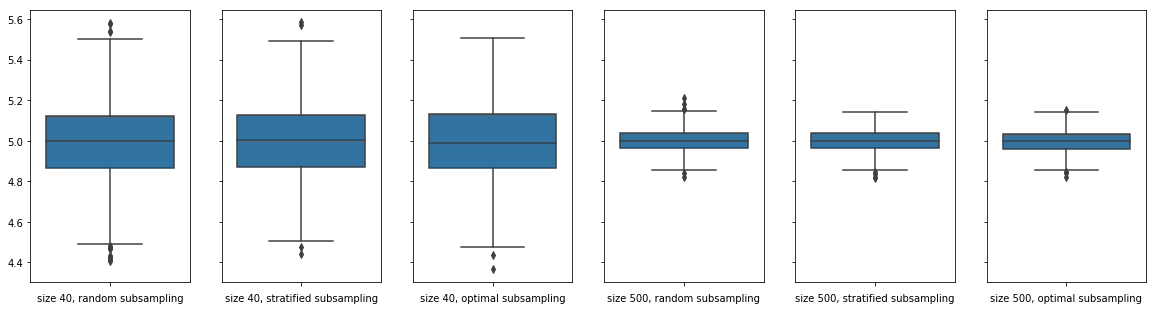

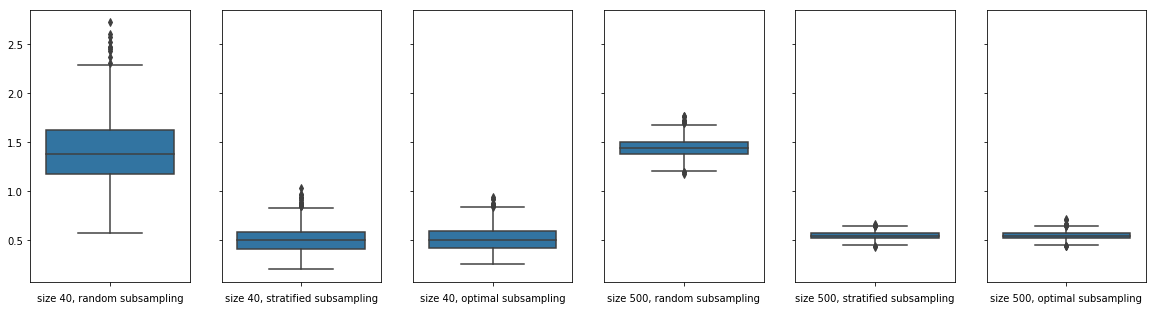

In [121]:
strats_mean, strats_std = [5, 5, 5], [1.2, 1.2, 1.2]
weights = [0.2, 0.5, 0.3]
samples_mean, samples_var = stratification(strats_mean, strats_std, weights)

_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_mean[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_mean[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);
    
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_var[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_var[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);

```
Здесь теоретическое МО = (0.2 * 5 + 0.5 * 8 + 0.3 * 12) = 8.6, теоретическая дисперсия = 0.2^2 * 1.4 + 0.5^2 * 1.4 + 0.3^2 * 1.4 = 0.532
```

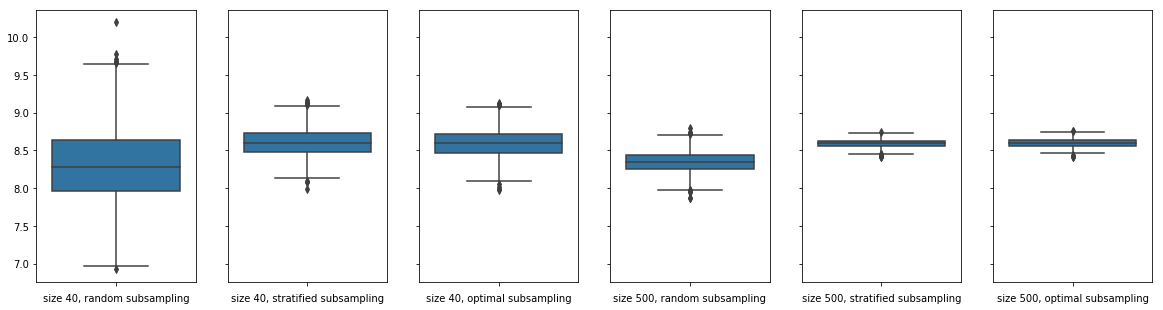

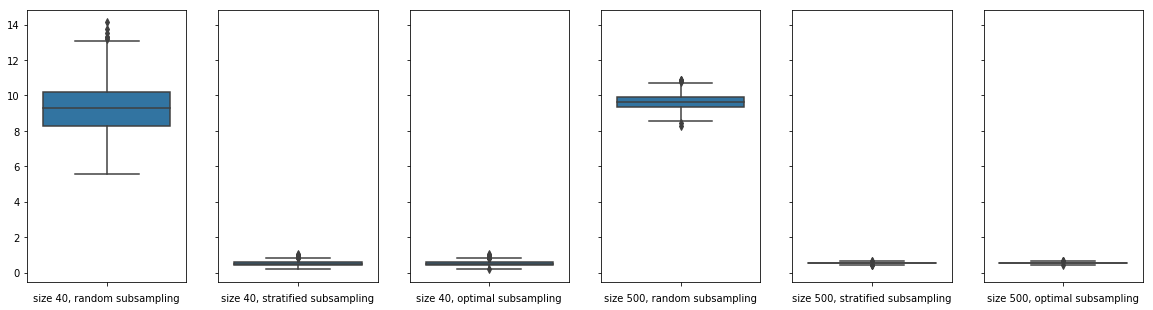

In [125]:
strats_mean, strats_std = [5, 8, 12], [1.2, 1.2, 1.2]
weights = [0.2, 0.5, 0.3]
samples_mean, samples_var = stratification(strats_mean, strats_std, weights)

_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_mean[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_mean[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);
    
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_var[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_var[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);

```
Здесь теоретическое МО = (0.2 * 5 + 0.5 * 8 + 0.3 * 12) = 8.6, теоретическая дисперсия = 0.2^2 * 9 + 0.5^2 * 2.25 + 0.3^2 * 4 = 1,2825
```

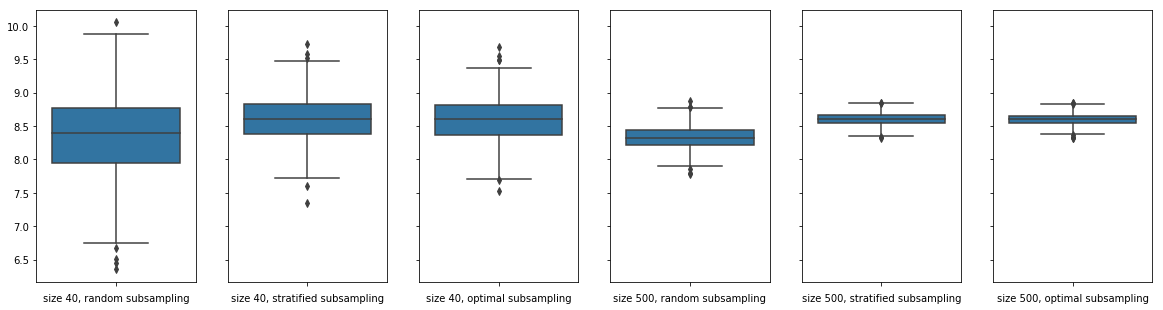

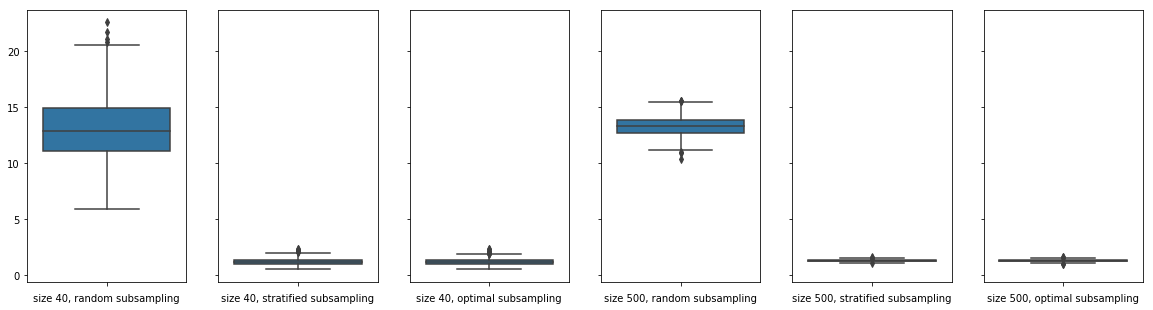

In [123]:
strats_mean, strats_std = [5, 8, 12], [3, 1.5, 2]
weights = [0.2, 0.5, 0.3]
samples_mean, samples_var = stratification(strats_mean, strats_std, weights)

_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_mean[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_mean[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);
    
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True) 

for j, way in enumerate(['random', 'stratified', 'optimal']):
    sns.boxplot(y=samples_var[40][way], ax=axes[j])
    axes[j].set_xlabel('size 40, %s subsampling' % way);
    
for j, way in enumerate(['random', 'stratified', 'optimal'], start=3):
    sns.boxplot(y=samples_var[500][way], ax=axes[j])
    axes[j].set_xlabel('size 500, %s subsampling' % way);

Вывод простой — стратифицированный и оптимальный subsampling дают гораздо более адекватные оценки, а также видна ЦПТ.

# Критерий Вальда

Две простых гипотезы

Примените к каждой из выборок из задачи по проверке статистических гипотез разобранной на семинаре последовательный критерий Вальда силы (α′,β′), используя приближенные границы, для проверки гипотезы H0:a=a0 при альтернативе H1:a=a1 , считая σ0 известным. Какой объем выборок потребовался в каждом случае? Выясните, не менее скольки наблюдений в среднем необходимо провести, если вы будете использовать последовательный критерий силы (α′,β′), в случае справедливости нулевой и альтернативной гипотез.

    * Критерий Вальда должен быть реализован самостоятельно

In [129]:
import math
import numpy as np
from scipy import stats

Здесь функция правдоподобия нормального распределения при заданных параметрах на заданной выборке, точнее произведение плотностей нормального распределения

In [285]:
def normal_likelihood(sample, sigma, a):
    n = len(sample)
    result = sum((xi - a)**2 for xi in sample)
    result = result / (-2 * sigma**2)
    result = math.exp(result)
    result = result / ((2*math.pi)**(n/2) * sigma**n)
    return result

Здесь собственно критерий. Руководствовался https://compscicenter.ru/media/slides/math_stat_2014_spring/2014_02_26_math_stat_2014_spring_1.pdf и этим https://compscicenter.ru/media/slides/math_stat_2016_spring/2016_02_29_math_stat_2016_spring_a2UKSZF.pdf

In [286]:
def sprt(sample, alpha, beta, sigma, a0, a1, debug=False):
    c0 = beta/(1-alpha)
    c1 = (1-beta)/alpha
    
    for i in range(1, len(sample)):
        ratio = normal_likelihood(sample[:i], sigma, a1) / normal_likelihood(sample[:i], sigma, a0)
        if debug:
            print('value: %f, upper: %f, lower: %f' % (ratio, c0, c1))
        if ratio < c0:
            if debug:
                print('H0 accepted')
            return True
        elif ratio > c1:
            if debug:
                print('H0 rejected')
            return False
    else:
        if debug:
            print('Can\'t say anything :c')
        return None

Здесь функция, генерирующая выборку, состоящую из a0_size элементов нормального распределения с параметрами a0 и sigma и a1_size элементов нормального распределения с параметрами a1 и sigma. Все элементы перемешиваются

In [287]:
def get_sample(sigma, a0, a1, a0_size, a1_size):
    sample1 = stats.norm(loc=a0, scale=sigma).rvs(size=a0_size)
    sample2 = stats.norm(loc=a1, scale=sigma).rvs(size=a1_size)
    sample = np.concatenate((sample1, sample2))
    np.random.shuffle(sample)
    return sample

Сгенерируем 1000 выборок с sigma = 2, a0 = 10, a0_size = 50, a1 = 11, a1_size = 25, посмотрим, сколько гипотез при alpha = 0.05, beta = 0.1 было принято, сколько отклонено, построим barplot

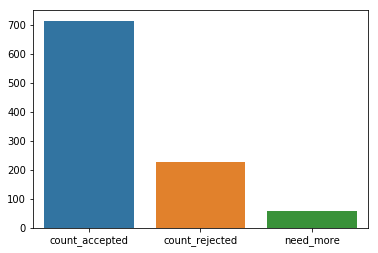

In [303]:
count_accepted, count_rejected, need_more = 0, 0, 0
for i in range(1000):
    sigma, a0, a1 = 2, 10, 11
    sample = get_sample(sigma=sigma, a0=a0, a1=a1, a0_size=50, a1_size=25)
    accepted = sprt(sample, 0.05, 0.1, sigma, a0, a1, debug=False)
    if accepted == True:
        count_accepted += 1
    elif accepted == False:
        count_rejected += 1
    else:
        need_more += 1
        
sns.barplot(y=[count_accepted, count_rejected, need_more], x=['count_accepted', 'count_rejected', 'need_more'])

Можно (и нужно) было упростить статистику Z (отношение ф-й правдоподобия), но... и так работает.

# ANOVA

Реализовать без использования библиотек

Есть ли взаимосвязь между размером мозга интеллектом http://lib.stat.cmu.edu/DASL/Stories/BrainSizeandIntelligence.html

Есть ли различия в выборе авто между мужчинами и женщинами http://www.statsci.org/data/oz/carprefs.html

    * Anova должно быть реализовано самостоятельно

In [74]:
import pandas as pd
import numpy as np
from scipy import stats

Рассмотрим первый датасет, прочитаем данные

In [75]:
df = pd.read_csv('./brain_size.csv', sep='\t')
df.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118.0,64.5,816932
1,Male,140,150,124,NaN,72.5,1001121
2,Male,139,123,150,143.0,73.3,1038437
3,Male,133,129,128,172.0,68.8,965353
4,Female,137,132,134,147.0,65.0,951545


В датасете представлены данные IQ тестов 40 человек, их антропометрические данные и (условно) размер мозга, вычисленный путем подсчета числа не-черных пикселей на МРТ.

Нужно с помощью ANOVA выяснить, есть ли зависимость между IQ и размером мозга.

Посмотрим, есть ли пропущенные значения в датасете.

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Gender       40 non-null object
FSIQ         40 non-null int64
VIQ          40 non-null int64
PIQ          40 non-null int64
Weight       38 non-null float64
Height       39 non-null float64
MRI_Count    40 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 2.3+ KB


Видим, что пропущенные значения есть, но не в последенем столбце и не в стобцах с IQ, поэтому они нас вообще не волнуют.

Отсортируем датасет по последнему столбцу MRI_Count, т.е. по размеру мозга, и поделим датасет на две части — на людей с маленьким мозгом и с большим, просто разделив интервал значений MRI_Count на две равные части и внеся эту информацию в столбец Brain_size. Воспользуемся вспомогательной функций group_values, которая и будет делить наш датасет на части

In [100]:
def group_values(df, target, source, n):
    """Divide pandas.DataFrame's `source` column values interval into n equal parts
    
    :param df: dataframe
    :type df: pandas.DataFrame
    :param target: name of column to store categorical value
    :type target: str
    :param source: name of column to divide dataframe
    :type source: str
    :params n: number of parts
    :type n: int
    """
    intervals = np.linspace(df[source].min(), df[source].max(), n+1)
    intervals[0] = -np.inf
    intervals[-1] = np.inf
    intervals = [item for item in zip(intervals[:-1], intervals[1:])]
    df[target] = 0
    for (i, interval) in enumerate(intervals, start=1):
        where = (interval[0] <= df[source]) & (df[source] < interval[1])
        df[target][where] = i

In [107]:
df = df.sort_values(by='MRI_Count')
group_values(df, 'Brain_size', 'MRI_Count', 2)
df.head(), df.tail()

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(    Gender  FSIQ  VIQ  PIQ  Weight  Height  MRI_Count  Brain_size
 22  Female   135  129  134   122.0    62.0     790619           1
 28  Female    77   83   72   106.0    63.0     793549           1
 26  Female    85   90   84   140.0    68.0     798612           1
 18  Female   101  112   84   136.0    66.3     808020           1
 0   Female   133  132  124   118.0    64.5     816932           1,
    Gender  FSIQ  VIQ  PIQ  Weight  Height  MRI_Count  Brain_size
 32   Male   103   96  110   192.0    75.5     997925           2
 1    Male   140  150  124     NaN    72.5    1001121           2
 2    Male   139  123  150   143.0    73.3    1038437           2
 27   Male   103   96  110   187.0    77.0    1062462           2
 11   Male   141  150  128   151.0    70.0    1079549           2)

Выдвинем нулевую гипотезу о равенстве средних в полученных двух группах. Посчитаем F-статистику и соответствующее p-value, посмотрим, что нам скажет тест. Для этого воспользуемся вспомогательной функцией anova.

In [102]:
def anova(df, dependent, independent, alpha=0.05):
    """Perform 1-way ANOVA
    
    :param df: dataframe with data
    :type df: pandas.DataFrame
    :param dependent: name of column with dependent variable
    :type dependent: str
    :param independent: name of column with independent variable
    :type independent: str
    :param alpha: alpha magic value
    :type alpha: float
    """
    
    total = df[dependent].values
    groups = [df[df[independent] == value][dependent].values for value in df[independent].unique()]
    groups_len = np.array([len(group) for group in groups])
    
    total_mean = np.mean(total)
    groups_mean = np.array([np.mean(group) for group in groups])
    
    ssb = np.sum(((groups_mean - total_mean) ** 2) * groups_len)
    ssw = np.sum(np.sum((group - group_mean) ** 2) for group, group_mean in zip(groups, groups_mean))
    
    ssb_df = len(groups)-1
    ssw_df = len(total)-len(groups)
    
    msb = ssb/ssb_df
    msw = ssw/ssw_df
    
    F = msb/msw
    
    p_value = 1 - stats.f.cdf(F, ssb_df, ssw_df)
    print('H0 %s, F: %f, p-value: %f' % ('rejected' if p_value < alpha else 'not rejected', F, p_value))

In [103]:
anova(df, 'FSIQ', 'Brain_size')

H0 rejected, F: 13.381590, p-value: 0.000767


Тест нам сказал, что при условии, что верна нулевая гипотеза, вероятность получить такие различия, как у нас, очень мала. Поэтому есть основания отклонить нулевую гипотезу.

Если заметить, что выборки несбалансированы по полу, а именно, что в группе людей с маленьким мозгом (там среднее **ниже**) сильно больше женщин, то в условиях результата теста можно предположить, что IQ зависит еще и от пола.

Попробуем разделить датасет на 3 группы и посмотреть, что будет в этом случае.

In [104]:
group_values(df, 'Brain_size', 'MRI_Count', 3)
anova(df, 'FSIQ', 'Brain_size')

H0 not rejected, F: 1.388311, p-value: 0.262190


/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Забавно, теперь p-value получилось довольно большим, и оснований отклонить нулевую гипотезу у нас в этот раз нет.

Рассмотрим второй датасет.

In [118]:
df = pd.read_csv('./carprefs.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 110 to 349
Data columns (total 21 columns):
Age          300 non-null int64
Sex          300 non-null int64
LicYr        300 non-null int64
LicMth       300 non-null int64
ActCar       300 non-null int64
Kids5        300 non-null int64
Kids6        300 non-null int64
PreferCar    300 non-null int64
Car15K       300 non-null int64
Reason       300 non-null int64
Cost         300 non-null int64
Reliable     300 non-null int64
Perform      300 non-null int64
Fuel         300 non-null int64
Safety       300 non-null int64
AC/PS        300 non-null int64
Park         300 non-null int64
Room         300 non-null int64
Doors        300 non-null int64
Prestige     300 non-null int64
Colour       300 non-null int64
dtypes: int64(21)
memory usage: 51.6 KB


Видим, что пропусков нет, замечательно. Выдвинем нулевую гипотезу о равенстве средних значений зависимых переменных в двух группах — мужчин и женщин. Проверим зависимость пола респондентов от их предпочтений в выборе автомобиля, а именно от PreferCar, Reason, Cost, Reliable, Perform, Fuel, Safety, AC/PS, Park, Room, Doors, Prestige, Colour. Выберем alpha = 0.01

In [125]:
for col in ['PreferCar', 'Reason', 'Cost', 'Reliable', 'Perform', 'Fuel', 'Safety', 'AC/PS', 'Park', 'Room',
            'Doors', 'Prestige', 'Colour']:
    anova(df, col, 'Sex', 0.01)

H0 rejected, F: 17.440907, p-value: 0.000039
H0 not rejected, F: 2.353237, p-value: 0.126084
H0 not rejected, F: 0.663756, p-value: 0.415888
H0 not rejected, F: 6.327847, p-value: 0.012411
H0 rejected, F: 7.991184, p-value: 0.005019
H0 rejected, F: 8.947740, p-value: 0.003010
H0 rejected, F: 37.191435, p-value: 0.000000
H0 rejected, F: 11.971587, p-value: 0.000619
H0 rejected, F: 36.007841, p-value: 0.000000
H0 not rejected, F: 2.216732, p-value: 0.137579
H0 not rejected, F: 2.222801, p-value: 0.137044
H0 not rejected, F: 1.341447, p-value: 0.247706
H0 not rejected, F: 4.526305, p-value: 0.034198


Видим, что примерно в половине случаев согласно тесту получаем основания отклонить нулевую гипотезу даже при alpha = 0.01, т.е. различия между мужчинами и женщинами при выборе автомобиля таки есть.